In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2
from segment_anything import SamAutomaticMaskGenerator, sam_model_registry, SamPredictor

sam = sam_model_registry["vit_b"](checkpoint="./sam_vit_b_01ec64.pth")
sam.to(device='cuda')
mask_generator = SamAutomaticMaskGenerator(sam)

def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

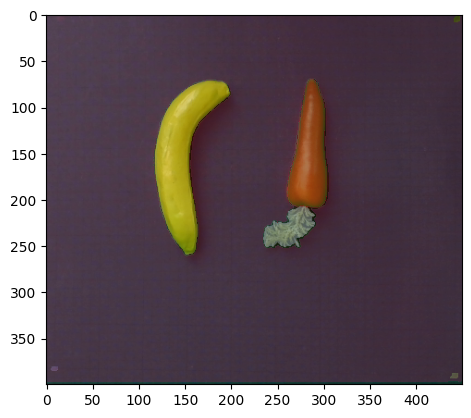

In [2]:
image = cv2.imread("./samples/rgb.png")[80:, 160:610] 
# So, this means that src.at(i,j) is using (i,j) as (row,column) but Point(x,y) is using (x,y) as (column,row)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

masks = mask_generator.generate(image)
plt.imshow(image)
show_anns(masks)
np.savez("./samples/masks.npz", masks=masks)

In [ ]:
image = cv2.imread("./easy.png")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

predictor = SamPredictor(sam)
predictor.set_image(image)

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
masks = np.load("./samples/masks.npz", allow_pickle=True)
masks = list(masks.values())[0]

(400, 450, 3)
[0, 0, 449, 397] 224 198
[118, 72, 80, 187] 158 165
[261, 70, 42, 138] 282 139
[235, 208, 55, 43] 262 229
[236, 70, 67, 181] 269 160
[5, 381, 7, 4] 8 383
[118, 71, 185, 188] 210 165
[441, 2, 6, 6] 444 5
[437, 388, 8, 5] 441 390


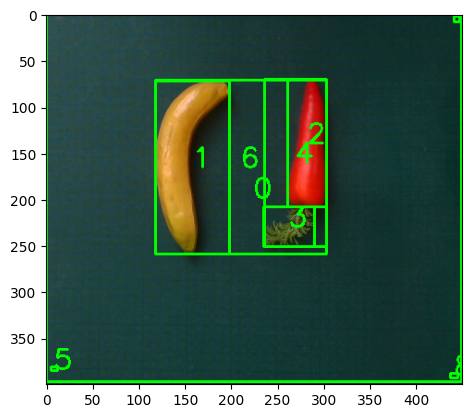

In [11]:
img = cv2.imread("./samples/rgb.png")
img = img[80:, 160:610]
print(img.shape)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

for idx, mask in enumerate(masks):
    # print x, y, w, h and center point
    center_x, center_y = mask['bbox'][0] + mask['bbox'][2]//2, mask['bbox'][1] + mask['bbox'][3]//2
    print(mask['bbox'], center_x, center_y)
    # draw rectangle
    # XYWH to X1Y1X2Y2
    cv2.rectangle(img, 
                  (mask['bbox'][0], mask['bbox'][1]), 
                  (mask['bbox'][0] + mask['bbox'][2], 
                   mask['bbox'][1] + mask['bbox'][3]), 
                   (0, 255, 0), 2)
    # draw a number label on the center of the rectangle
    cv2.putText(img, str(idx), (center_x, center_y), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

In [9]:
def calculate_iou(box1, box2):
    """
    计算两个边界框的IoU
    box格式为(x, y, w, h)
    """
    x1, y1, w1, h1 = box1
    x2, y2, w2, h2 = box2
    
    xi1 = max(x1, x2)
    yi1 = max(y1, y2)
    xi2 = min(x1 + w1, x2 + w2)
    yi2 = min(y1 + h1, y2 + h2)
    
    inter_area = max(0, xi2 - xi1) * max(0, yi2 - yi1)
    box1_area = w1 * h1
    box2_area = w2 * h2
    union_area = box1_area + box2_area - inter_area
    
    iou = inter_area / union_area
    return iou

def is_contained(box1, box2):
    """
    检查box1是否被box2完全包含
    box格式为(x, y, w, h)
    """
    x1, y1, w1, h1 = box1
    x2, y2, w2, h2 = box2
    
    return (x1 >= x2 and y1 >= y2 and
            x1 + w1 <= x2 + w2 and y1 + h1 <= y2 + h2)

def filter_overlapping_masks(bounding_boxes, min_iou=0.5):
    """
    过滤重叠的masks
    bounding_boxes: 列表，每个元素为(x, y, w, h)格式的边界框
    min_iou: 最小IoU阈值
    返回值: 过滤后的边界框列表
    """
    filtered_boxes = []
    num_boxes = len(bounding_boxes)
    
    for i in range(num_boxes):
        keep = True
        for j in range(num_boxes):
            if i != j:
                iou = calculate_iou(bounding_boxes[i], bounding_boxes[j])
                if iou >= min_iou or is_contained(bounding_boxes[i], bounding_boxes[j]):
                    if (bounding_boxes[i][2] * bounding_boxes[i][3]) < (bounding_boxes[j][2] * bounding_boxes[j][3]):
                        keep = False
                        break
        if keep:
            filtered_boxes.append(bounding_boxes[i])
    
    return filtered_boxes

bounding_boxes = [mask['bbox'] for mask in masks[1:]]
filtered_boxes = filter_overlapping_masks(bounding_boxes, min_iou=0.5)
print(filtered_boxes)


[[236, 70, 67, 181], [5, 381, 7, 4], [118, 71, 185, 188], [441, 2, 6, 6], [437, 388, 8, 5]]


164711
6853
4125
1480
5565
36
10804
44
46
(400, 450, 3)
[118, 72, 80, 187] 158 165
[261, 70, 42, 138] 282 139
[236, 70, 67, 181] 269 160
[118, 71, 185, 188] 210 165


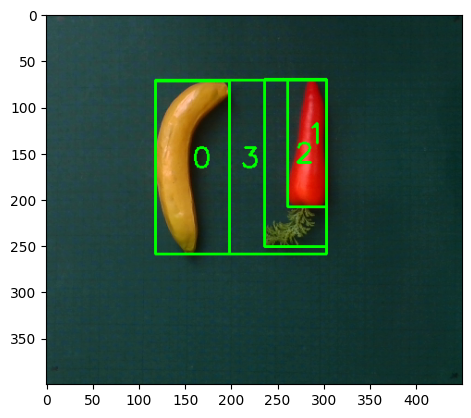

In [5]:
def filter_masks_by_area(masks, min_area_ratio=0.01, max_area_ratio=0.25):
    """
    过滤占据面积过小或过大的masks
    min_area_ratio: 最小面积占比阈值（相对于整张图的面积）
    max_area_ratio: 最大面积占比阈值（相对于整张图的面积）
    返回值: 过滤后的masks列表
    """
    filtered_masks = []
    image_area = masks[0]['segmentation'].shape[0] * masks[0]['segmentation'].shape[1]
    min_area = min_area_ratio * image_area
    max_area = max_area_ratio * image_area
    
    for mask in masks:
        print(mask['area'])
        if min_area <= mask['area'] <= max_area:
            filtered_masks.append(mask)
    
    return filtered_masks

filtered_masks = filter_masks_by_area(masks, min_area_ratio=0.01, max_area_ratio=0.25)

img = cv2.imread("./samples/rgb.png")
img = img[80:, 160:610]
print(img.shape)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

for idx, mask in enumerate(filtered_masks):
    # print x, y, w, h and center point
    center_x, center_y = mask['bbox'][0] + mask['bbox'][2]//2, mask['bbox'][1] + mask['bbox'][3]//2
    print(mask['bbox'], center_x, center_y)
    # draw rectangle
    # XYWH to X1Y1X2Y2
    cv2.rectangle(img, 
                  (mask['bbox'][0], mask['bbox'][1]), 
                  (mask['bbox'][0] + mask['bbox'][2], 
                   mask['bbox'][1] + mask['bbox'][3]), 
                   (0, 255, 0), 2)
    # draw a number label on the center of the rectangle
    cv2.putText(img, str(idx), (center_x, center_y), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

(400, 450, 3)
[236, 70, 67, 181] 269 160
[5, 381, 7, 4] 8 383
[118, 71, 185, 188] 210 165
[441, 2, 6, 6] 444 5
[437, 388, 8, 5] 441 390


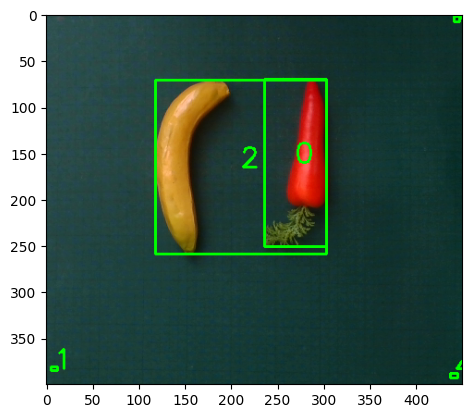

In [12]:
img = cv2.imread("./samples/rgb.png")
img = img[80:, 160:610]
print(img.shape)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

for idx, bbox in enumerate(filtered_boxes):
    # print x, y, w, h and center point
    center_x, center_y = bbox[0] + bbox[2]//2, bbox[1] + bbox[3]//2
    print(bbox, center_x, center_y)
    # draw rectangle
    # XYWH to X1Y1X2Y2
    cv2.rectangle(img, 
                  (bbox[0], bbox[1]), 
                  (bbox[0] + bbox[2], 
                   bbox[1] + bbox[3]), 
                   (0, 255, 0), 2)
    # draw a number label on the center of the rectangle
    cv2.putText(img, str(idx), (center_x, center_y), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

depth = np.load("./samples/depth_data.npy")[80:, 160:610]
depth = np.where(depth < 0.63, 0, 255)
plt.imshow(depth, cmap='gray')